
# Linear Regression Example
The example below uses a [marketing](https://scikit-learn.org/stable/datasets/toy_dataset.html) dataset,
in order to illustrate a linear regression activity.

Workflow:



1. Preparation
    1. Load the dataset from a `.csv` file and show a short description
    1. Show the two dimensional scatter plots for all the predicting variables with respect to the target
    1. Split the data into *predicting variables* `X` and *target* `y`
        1. here we set the `random_state` variable to make the experiment *repeatable* 
1. First experiment: compute the regression on a single predicting variable
    1. Consider a reduced dataset containing the chosen variable and the target
    1. Fit the `LinearRegression` estimator on the training set
    1. Show the statistical significance of the fitted model
    1. Predict the target for the test set using the *fitted* estimator
    1. Compute the regression coefficients and the quality measures: *Root Mean Squared Error (RMSE)* and *coefficient of determination (r2)*
1. Second experiment: compute the regression considering all the predicting variables
    1. Repeat the steps from 2.2 to 2.5
1. Third experiment: use the `DecisionTreeRegressor` with the entire dataset
    1. Fit the tree using the default hyperparameters, in order to find the 
    maximum depth of the unconstrained tree
    1. Use *cross-validation* to find the optimal *maximum depth* of the tree
    1. Fit the tree with the optmal `max_depth`
    1. Predict and show the *root mean squared error*
1. Fourth experiment: use the `RandomForestRegressor`
    1. Repeat steps from 4.2 to 4.4 (for simplicity, we use the maximum `max_depth` found in 4.1)


In [1]:
# Code source: Claudio Sartori 
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
from sklearn.model_selection import train_test_split

random_state = 94922767 # this will be used to guarantee the repeatability of the experiment

## Load the dataset from a `.xlsx` file and show a short description

In [2]:
# This cell allows full compatibility between execution in Google Colab and in local
try:
  import google.colab.files
  IN_COLAB = True
except:
  IN_COLAB = False
# from google.colab import files
if IN_COLAB:
    uploaded = files.upload()

In [3]:
# The file must be available in the same directory, 
# or uploaded in the Colab environment 
# in the execution of the previous cell
data_fn = 'FoodUK2014.xlsx'
df0 = pd.read_excel(data_fn)

## Data Exploration and preparation

##### Show a short description of the columns

In [4]:
df0.describe()

,hhsize,adults_n,children_n,totalexp,Year,income,AgeHRP,qmeat,qfish,qfv,xmeat,xfish,xfv,uvmeat,uvfish,uvfv
count,5114.000000,5114.000000,5114.000000,5114.000000,5114.0,5114.000000,5114.000000,4873.000000,3542.000000,5017.000000,4873.000000,3542.000000,5017.000000,4873.000000,3542.000000,5017.000000
mean,2.363707,1.841807,0.521901,519.898868,2014.0,679.542002,53.802698,10.475023,2.146960,25.727801,68.108342,19.635469,58.943391,7.072523,9.934257,2.508315
std,1.244704,0.743052,0.945622,411.543093,0.0,499.596175,16.187912,8.798118,2.034353,18.371345,57.347230,18.725096,44.751694,2.931651,5.485175,1.358023
min,1.000000,0.000000,0.000000,-246.916821,2014.0,0.000000,17.000000,0.086667,0.108333,0.060667,0.195000,0.000000,0.520000,0.357694,0.000000,0.159672
25%,1.000000,1.000000,0.000000,260.598783,2014.0,306.954000,41.000000,4.452500,0.866667,12.222167,29.141668,6.917083,27.148333,5.171614,5.979375,1.760525
50%,2.000000,2.000000,0.000000,426.977227,2014.0,548.086000,54.000000,8.374167,1.625000,22.245817,54.708336,13.736667,49.356667,6.575851,8.804690,2.254208
75%,3.000000,2.000000,1.000000,651.003763,2014.0,925.652500,67.000000,14.005333,2.816667,35.037167,90.480003,26.000000,78.281662,8.295746,12.520942,2.893561
max,9.000000,7.000000,7.000000,5859.877186,2014.0,2134.090000,80.000000,104.589333,41.348362,169.283829,803.465027,194.869995,480.024994,40.000000,46.315834,32.666668


##### Show the number of rows with nulls

It is computed subtracting the number of rows in the dataset without nulls from the original number of rows

In [5]:
# obtaining all null rows
withnull = df0[df0.isnull().any(axis=1)]
len(withnull)

1668

#### Drop rows with nulls

In [6]:
df = df0.dropna(axis=0)
len(df)

3446

##### Data transormation
- Convert the alphanumeric SexHRP into numeric 0 and 1
    - the `sklearn` machine learning procedures work only with numeric predicting
      attributes
- Generate two new columns as ratio of other columns
    - this is suggested by background information

In [7]:
# convert alphanumeric SexHRP
df.loc[df["SexHRP"] == 'Male', "SexHRP"] = 1
df.loc[df["SexHRP"] == 'Female', "SexHRP"] = 0

# alternately it can be used np.where() function
# df["SexHRP"] = np.where(df["SexHRP"] == "Female", 0, 1)


# Generate two new colums
qmeat_ratio = df["qmeat"] / df["hhsize"]
income_ratio = df["income"] / df["hhsize"]

df = df.assign(qmeat_hhsize_ratio=qmeat_ratio)
df = df.assign(income_hhsize_ratio=income_ratio)

df.head()

,hhsize,quarter,adults_n,children_n,totalexp,SexHRP,month,Gorx,Year,income,...,qfish,qfv,xmeat,xfish,xfv,uvmeat,uvfish,uvfv,qmeat_hhsize_ratio,income_hhsize_ratio
1,4,July to September,2,2,737.685635,1,August,North East,2014,824.520,...,0.650000,30.203335,53.278336,6.500000,62.833336,8.813621,10.000000,2.080344,1.511250,206.130000
2,2,October to December,2,0,330.775000,1,October,Northern Ireland,2014,271.925,...,2.088667,17.032166,93.838333,28.491667,42.813335,7.965790,13.641079,2.513675,5.890083,135.962500
4,3,April to June,3,0,880.787157,1,April,East Midlands,2014,496.040,...,2.903333,7.345000,73.623337,16.921667,19.261665,5.726323,5.828358,2.622419,4.285667,165.346667
5,4,January to March,2,2,372.275578,1,February,Wales,2014,266.530,...,1.789667,27.378000,303.181671,28.773333,86.558327,8.451528,16.077482,3.161602,8.968250,66.632500
7,3,January to March,3,0,151.750522,1,January,Eastern,2014,403.180,...,3.003000,6.742667,72.258331,26.000000,17.376667,5.904745,8.658009,2.577121,4.079111,134.393333


##### Use only the columns that the experts consider interesting
This is suggested by background information

In [8]:
df = df.loc[:, ['adults_n', 'children_n', 'SexHRP', 'AgeHRP', 'qmeat_hhsize_ratio', 'income_hhsize_ratio', 'uvmeat']]
df.head()

,adults_n,children_n,SexHRP,AgeHRP,qmeat_hhsize_ratio,income_hhsize_ratio,uvmeat
1,2,2,1,38,1.511250,206.130000,8.813621
2,2,0,1,54,5.890083,135.962500,7.965790
4,3,0,1,64,4.285667,165.346667,5.726323
5,2,2,1,70,8.968250,66.632500,8.451528
7,3,0,1,64,4.079111,134.393333,5.904745


## Choose the target and split the data into *predicting variables* `X` and *target* `y`

In [9]:
y = df['qmeat_hhsize_ratio']
X = df.loc[:, df.columns != 'qmeat_hhsize_ratio']

## Show the two dimensional scatter plots for all the predicting variables with respect to the target

In [10]:
ncols=3
import math
nrows = math.ceil((df.shape[1]-1)/ncols)
figwidth = ncols * 7
figheigth = nrows*5

[Text(0.5, 0, 'uvmeat'), Text(0, 0.5, '')]

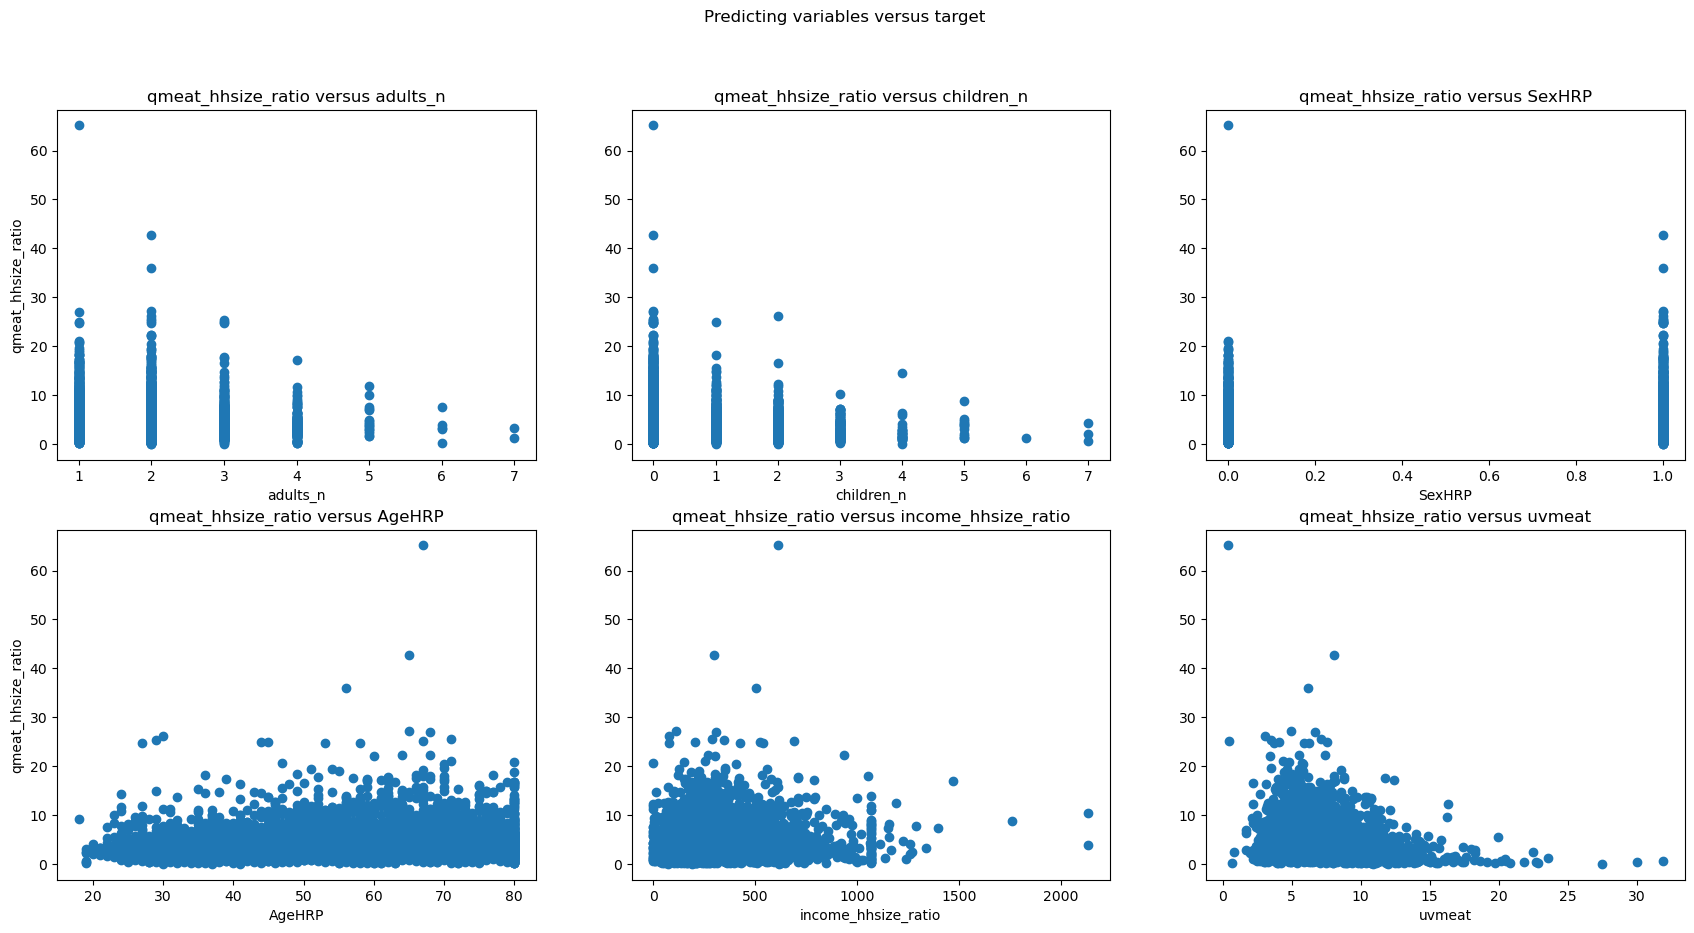

In [11]:
fig, axs = plt.subplots(2, 3, figsize=(figwidth, figheigth))
fig.suptitle('Predicting variables versus target')
axs[0,0].scatter(X['adults_n'], y)
axs[0,0].set_title('qmeat_hhsize_ratio versus adults_n')
axs[0,0].set(xlabel='adults_n', ylabel='qmeat_hhsize_ratio')
axs[0,1].scatter(X['children_n'], y)
axs[0,1].set_title('qmeat_hhsize_ratio versus children_n')
axs[0,1].set(xlabel='children_n', ylabel='')
axs[0,2].scatter(X['SexHRP'], y)
axs[0,2].set_title('qmeat_hhsize_ratio versus SexHRP')
axs[0,2].set(xlabel='SexHRP', ylabel='')
axs[1,0].scatter(X['AgeHRP'], y)
axs[1,0].set_title('qmeat_hhsize_ratio versus AgeHRP')
axs[1,0].set(xlabel='AgeHRP', ylabel='qmeat_hhsize_ratio')
axs[1,1].scatter(X['income_hhsize_ratio'], y)
axs[1,1].set_title('qmeat_hhsize_ratio versus income_hhsize_ratio')
axs[1,1].set(xlabel='income_hhsize_ratio', ylabel='')
axs[1,2].scatter(X['uvmeat'], y)
axs[1,2].set_title('qmeat_hhsize_ratio versus uvmeat')
axs[1,2].set(xlabel='uvmeat', ylabel='')




### Show the *_p-values_* of the target with respect to the variables

In [12]:
from sklearn.feature_selection import f_regression
# Your code here

variables = ['adults_n', 'children_n', 'SexHRP', 'AgeHRP', 'income_hhsize_ratio', 'uvmeat']
_, p = f_regression(X, y)

pvalues = pd.DataFrame()
pvalues['variable'] = variables
pvalues['p-value'] = p
pvalues.head()

,variable,p-value
0,adults_n,1.415945e-05
1,children_n,1.077386e-30
2,SexHRP,8.429827e-02
3,AgeHRP,1.710126e-21
4,income_hhsize_ratio,1.211099e-03


## Split the data into *train* and *test* and show the sizes of the two parts
Here we set the `random_state` variable to make the experiment *repeatable*


In [13]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=random_state, train_size=0.7)

print('Train: ' + str(len(Xtrain)))
print('Test: ' + str(len(Xtest)))

Train: 2412
Test: 1034


### Consider a reduced dataset containing the chosen variable and the target

In [14]:
prediction_variable = 'adults_n'

Xtrain_r = Xtrain[prediction_variable].values.reshape(-1, 1)
Xtest_r = Xtest[prediction_variable].values.reshape(-1, 1)

### Fit the `linear_model` estimator on the training set and predict the target for the test set using the *fitted* estimator

In [15]:
linear = linear_model.LinearRegression()

linear.fit(Xtrain_r, ytrain)

ytrain_pred = linear.predict(Xtrain_r)
ytest_pred = linear.predict(Xtest_r)

#### Compute the regression coefficients and the quality measures
Create a function to compute the F-statistic and p-value of the regression model

In [16]:
# Computation of F-statistic and p-value for the regression
# http://facweb.cs.depaul.edu/sjost/csc423/documents/f-test-reg.htm

def f_test(y_true, y_pred, n_var, n_obs):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    n = n_obs
    p = n_var + 1
    y_true_m = np.mean(y_true)
    SSM = np.sum((y_pred - y_true_m)**2)
    SSE = np.sum((y_true - y_pred)**2)
    SST = np.sum((y_true - y_true_m)**2)
    DFM = p - 1
    DFE = n - p
    DFT = n - 1
    MSM = SSM / DFM
    MSE = SSE / DFE
    MST = SST / DFT
    F = MSM / MSE
    p = 1 - scipy.stats.f.cdf(F, DFM, DFE)
    return F, p

#### Compute the statistical significance of the model

In [18]:
f_statistic_uni, p_value_uni = f_test(ytrain, ytrain_pred, Xtrain_r.shape[1], Xtrain_r.shape[0])

# coefficient
coeff_uni = linear.coef_[0]
intercept_uni = linear.intercept_

# the root mean squared error
rmse_uni = mean_squared_error(ytest, ytest_pred, squared=False)

# coefficient of determination = 1 is perfect prediction
r2_uni = r2_score(ytest, ytest_pred)

# the results are assembled in a dataframe for a compact view
pd.DataFrame({'Univariate Linear - Value' : [intercept_uni,
                        coeff_uni,
                        rmse_uni,
                        r2_uni,
                        f_statistic_uni,
                        p_value_uni]}
                , index = ['Intercept for"{}"'.format(prediction_variable),
                            'Coefficient for"{}"'.format(prediction_variable),
                            'rmse',
                            'r2',
                            'f-statistic',
                            'p-value'])

,Univariate Linear - Value
"Intercept for""adults_n""",5.646984
"Coefficient for""adults_n""",-0.326893
rmse,3.886323
r2,0.007595
f-statistic,9.841162
p-value,0.001727


## Second experiment: compute the regression considering all the predicting variables

### Now we use the entire data in `X_train` and `X_test` for fitting and predicting

In [19]:
linear_multi = linear_model.LinearRegression()

linear_multi.fit(Xtrain, ytrain)

y_train_pred_multi = linear_multi.predict(Xtrain)
y_test_pred_multi = linear_multi.predict(Xtest)

### Fit, predict and show the results
Now we see the *regression coefficients* resulting from the fitting. 

In particular, *positive coefficients* indicate that the target *increases* with the variable, *negative coefficients* indicate a *decreasing* trend.

The absolute values of the coefficient cannot be considered directly a measure of importance, due to the possibly different orders of magnitude of the data in the different columns (observe above the outputs of `describe`).

,Variable,Coefficient
0,adults_n,-0.318682
1,children_n,-0.650924
2,SexHRP,0.383162
3,AgeHRP,0.014913
4,income_hhsize_ratio,0.000989
5,uvmeat,-0.392620


#### Compute the statistical significance

,Variable,p-value
0,adults_n,4.812836e-19
1,children_n,1.384315e-188
2,SexHRP,5.806116e-10
3,AgeHRP,3.199609e-119
4,income_hhsize_ratio,6.460728e-08
5,uvmeat,0.000000e+00


#### Compute the quality measures

,Univariate Linear - Value
rmse,3.6651
r2,0.1173
f-statistic,57.4179
p-value,0.0000


## Decision Tree Multivariate Regresson

In [24]:
# Create Decision Tree regression object
from sklearn.tree import DecisionTreeRegressor

#### Fit the tree with default hyperparameters, and find the maximum depth of the unconstrained tree

The maximum depth of the full Decision Tree Regressor is 34


#### Find the optimal value of the hyperparameter `max_depth` with *cross-validation*
The optimization searches for the *maximum tree depth* guaranteing the smallest mean squared error
At the end, this operation returns also the *fitted best tree* `best_estimator_`

The optimal maximum depth for the decision tree is 2


Decision Tree Regression - RMSE = 3.79


#### Show the tree

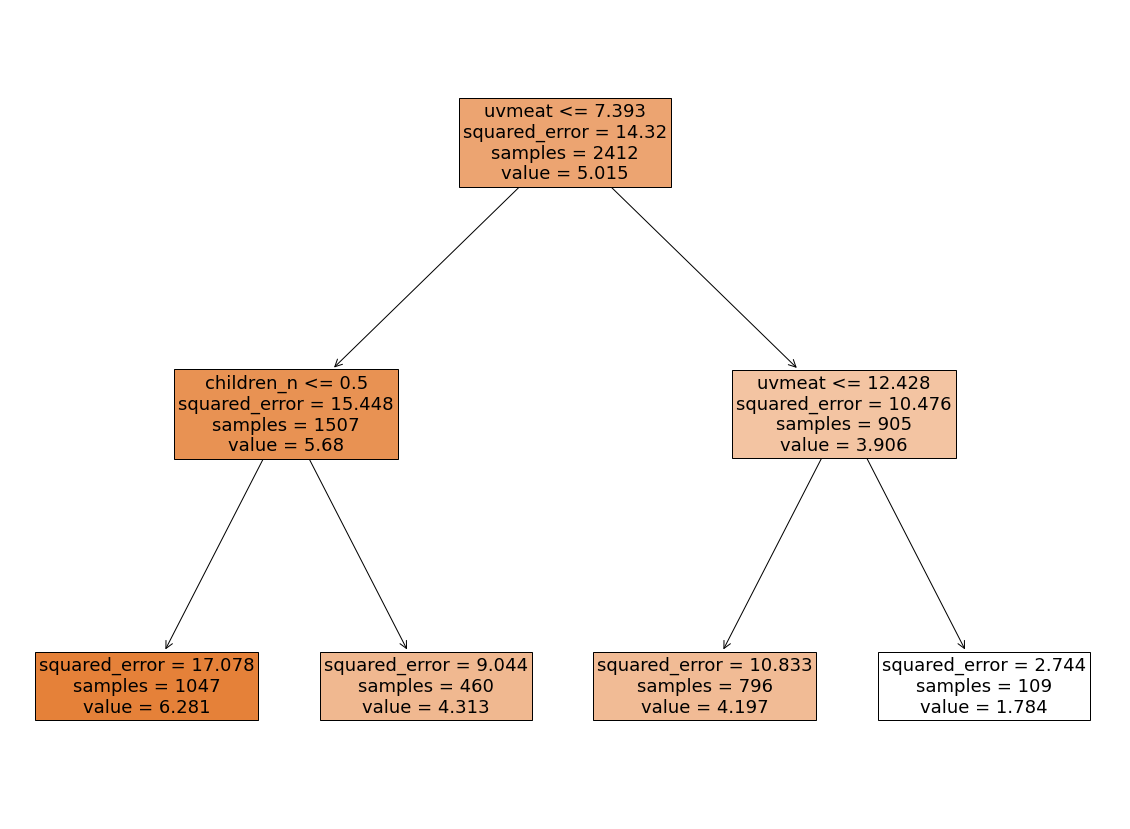

In [28]:
from sklearn.tree import plot_tree
from matplotlib.pyplot import figure
# Your code here

## Random Forest Multivariate Regresson
Create a Random forest regressor and fit it on the complete dataset.

For simplicity use the max_depth found in the Decision tree regressor to perform a cross validation and find the best depth for this model.

The optimal maximum depth for the trees in the random forest is 4


Random Forest Regression - RMSE = 3.58


## Final observations
### Linear regression
The multivariate regression with all the predicting variables available with respect to the univariate regression has 
- lower RMSE 
- higher coefficient of determination 
- the p-value suggests the acceptance of both models
### Decision Tree and Random Forest regression
- Decistion Tree has an RMSE slightly higher than multivariate linear regression
- Random Forest has an RMSE slightly lower than multivariate linear regression


## Control questions
1. observing the multi-variate experiment, what variable has the higher effect on the target?
1. is there a variable having an almost negligible effect on the target?
1. try to repeat the univariate experiment with the other two columns and comment the results